### mining 모듈이 Import 되지 않을 때 실행
---
```python
import sys
import os

os.chdir("<mining 디렉토리의 root directory 주소>") # root로 설정해야, mining, clustering 모두 접근가능
current_dir = os.path.abspath(os.getcwd()) 
if current_dir not in sys.path: sys.path.insert(0, current_dir)
```

### 1. One Step EDA
---

In [1]:
from mining import one_step_EDA_from_bigquery 
import warnings
warnings.filterwarnings('ignore')

eda = one_step_EDA_from_bigquery(
    path="key.json", 
    limit=None, 
    start_name='start', 
    end_name='end', 
    case_type=None
)

case_lengths
5     1010
4      924
6      888
3      612
7      546
8      248
9      153
10      30
13      13
12      12
11      11
Name: count, dtype: int64


In [2]:
eda.Transition.Frequency.all_cnts

,Source,Target,Variable
0,start,SI,617
1,start,SL,234
2,start,CH,32
3,start,FF,2
4,SI,SL,592
6,SI,SI,1873
7,SI,CH,58
8,SL,SI,597
10,SL,SL,209
11,SL,CH,17


In [3]:
eda.Transition.Probability.visualizer(layered=True, grouped=False)

### 2. step by step (Dataframe → EDA)
---

In [4]:
from mining.utils import load_data_from_bigquery
from mining.preprocessing import define_at_bat_cases
from mining.preprocessing import add_node_and_preprocess
from mining.preprocessing import one_way_filter
from mining.probability import BasedTraces
from mining.exploratory import ProcessEDA

In [5]:
df = load_data_from_bigquery()
df[['game_date', 'batter', 'pitch_type','events']].head(10)

,game_date,batter,pitch_type,events
0,2019-10-01,665742,SI,single
1,2019-10-01,665742,SL,None
2,2019-10-01,665742,SI,None
3,2019-10-01,543685,SI,walk
4,2019-10-01,543685,SI,None
5,2019-10-01,543685,SI,None
6,2019-10-01,543685,SI,None
7,2019-10-01,543685,SI,None
8,2019-10-01,543685,SI,None
9,2019-10-01,475582,SI,single


In [6]:
df_grouped = define_at_bat_cases(df)
df_grouped.head(10)[['game_date', 'batter', 'pitch_type', 'events','processID', 'pitchOrder']]

case_lengths
5     1010
4      924
6      888
3      612
7      546
8      248
9      153
10      30
13      13
12      12
11      11
Name: count, dtype: int64


,game_date,batter,pitch_type,events,processID,pitchOrder
0,2019-10-01,665742,SI,single,0,0
1,2019-10-01,665742,SL,None,0,1
2,2019-10-01,665742,SI,None,0,2
3,2019-10-01,543685,SI,walk,1,0
4,2019-10-01,543685,SI,None,1,1
5,2019-10-01,543685,SI,None,1,2
6,2019-10-01,543685,SI,None,1,3
7,2019-10-01,543685,SI,None,1,4
8,2019-10-01,543685,SI,None,1,5
9,2019-10-01,475582,SI,single,2,0


In [7]:
df_grouped.groupby('processID').events.size().value_counts()

events
4     231
3     204
5     202
6     148
7      78
8      31
9      17
10      3
13      1
12      1
11      1
Name: count, dtype: int64

In [8]:
# 시작, 종료 노드 추가
df_added = add_node_and_preprocess(df_grouped, start_name='start', end_name='end', case_type=None)
display(df_added.head(10)[['case:concept:name','time:timestamp', 'batter', 'pitch_type', 'events', 'pitchOrder']])

print('\n === 구종 테이블 ===')
display(df_added.pitch_type.value_counts().to_frame())

print('\n === Events 테이블 ===')
display(df_added.events.value_counts().to_frame())


,case:concept:name,time:timestamp,batter,pitch_type,events,pitchOrder
4339,0,2019-10-01 00:00:01,665742,start,None,-1
0,0,2019-10-01 00:00:00,665742,SI,single,0
1,0,2019-10-01 00:00:01,665742,SL,None,1
2,0,2019-10-01 00:00:02,665742,SI,None,2
4340,0,2019-10-01 00:00:01,665742,end,single,3
4341,1,2019-10-01 00:00:04,543685,start,None,-1
3,1,2019-10-01 00:00:00,543685,SI,walk,0
4,1,2019-10-01 00:00:01,543685,SI,None,1
5,1,2019-10-01 00:00:02,543685,SI,None,2
6,1,2019-10-01 00:00:03,543685,SI,None,3



 === 구종 테이블 ===


,count
pitch_type,
SI,3159
SL,1060
start,885
end,885
CH,118
FF,2



 === Events 테이블 ===


,count
events,
strikeout,902
field_out,414
walk,206
single,110
home_run,38
double,36
hit_by_pitch,28
force_out,10
grounded_into_double_play,8


In [9]:
# strikeout만 filtering
df_filtered = one_way_filter(df_added, colName = 'events', posCondition = ['strikeout'])
display(df_filtered.head(10)[['case:concept:name','time:timestamp', 'batter', 'pitch_type', 'events', 'pitchOrder']])

print('\n === 구종 테이블 ===')
display(df_filtered.pitch_type.value_counts().to_frame())

print('\n === Events 테이블 ===')
display(df_filtered.events.value_counts().to_frame())


,case:concept:name,time:timestamp,batter,pitch_type,events,pitchOrder
4339,0,2019-10-01 00:00:01,665742,start,None,-1
0,0,2019-10-01 00:00:00,665742,SI,single,0
1,0,2019-10-01 00:00:01,665742,SL,None,1
2,0,2019-10-01 00:00:02,665742,SI,None,2
4340,0,2019-10-01 00:00:01,665742,end,single,3
4341,1,2019-10-01 00:00:04,543685,start,None,-1
3,1,2019-10-01 00:00:00,543685,SI,walk,0
4,1,2019-10-01 00:00:01,543685,SI,None,1
5,1,2019-10-01 00:00:02,543685,SI,None,2
6,1,2019-10-01 00:00:03,543685,SI,None,3



 === 구종 테이블 ===


,count
pitch_type,
SI,3159
SL,1060
start,885
end,885
CH,118
FF,2



 === Events 테이블 ===


,count
events,
strikeout,902
field_out,414
walk,206
single,110
home_run,38
double,36
hit_by_pitch,28
force_out,10
grounded_into_double_play,8


In [10]:
# Event Log 데이터를 Probability로 계산
calc_eventlog = BasedTraces(df_filtered) 
final_result = calc_eventlog()

# Process EDA
eda = ProcessEDA(final_result)

In [11]:
from pm4py.algo.filtering.log.variants.variants_filter import get_variants

event_log = final_result['event_log']
variants = get_variants(event_log)
for v in variants:
    # print(v)
    traces = variants[v][0]
    # print(traces)

# 모든 Case ID를 추출하려면
CASE_ID_KEY = 'case:concept:name'
all_case_ids_in_this_variant = [
    trace.attributes
    for trace in variants[v] # variants[v] 리스트 전체를 순회
]

In [12]:
eda.Transition.Frequency.all_cnts

,Source,Target,Variable
0,start,SI,617
1,start,SL,234
2,start,CH,32
3,start,FF,2
4,SI,SL,592
6,SI,SI,1873
7,SI,CH,58
8,SL,SI,597
10,SL,SL,209
11,SL,CH,17


In [13]:
eda.Descriptive.maximum_frequencey

Top 1 Frequency Variant : start → SI → SI → SI → end, 빈도: 77회, 길이: 3
Minimum Frequency Variant : start → SL → SL → SI → SI → SI → SL → SI → SI → end, 빈도: 1회, 길이: 8
--------------------------------------------------
Maximum Length Variant : start → SI → SI → SL → SI → SL → SI → SI → SI → SI → SI → SI → SI → SI → end, 길이: 13, 빈도: 1회
Minimum Length Variant : start → SI → SL → SI → end, 길이: 3, 빈도: 18회


In [14]:
eda.Transition.Probability.visualizer(layered=True, grouped=False)

### 3. step by step (Daraframe → Clustering)
---

In [15]:
from clustering.distance import ClusteredTraces
from clustering.visualizer import MDS, Dendrogram

In [16]:
# Traces 별 Levinsutain
clusted = ClusteredTraces(df_filtered)
final_results = clusted(n_clusters = 3)

In [17]:
display(final_results['traces'][:5])
display(final_results['sequences'][:5])
display(final_results['labels'][:5])
display(final_results['clusters'])

[{'attributes': {'concept:name': 0}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}]},
 {'attributes': {'concept:name': 1}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:04+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}]},
 {'attributes': {'concept:name': 2}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:02+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}]},
 {'attributes': {'concept:name': 3}, 'events': [{'concept:name': 'start', 'time:timestamp': Timestamp('2019-10-01 00:00:03+0000', tz='UTC')}, '..', {'concept:name': 'end', 'time:timestamp': Timestamp('2019-10-01 00:00:01+0000', tz='UTC')}]},
 {'attributes': {'concept:name':

[['start', 'SI', 'SL', 'SI', 'end'],
 ['start', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'end'],
 ['start', 'SI', 'SL', 'SI', 'SL', 'end'],
 ['start', 'SI', 'SI', 'SI', 'SI', 'SL', 'end'],
 ['start', 'SI', 'SL', 'SI', 'SI', 'SI', 'SI', 'end']]

['T00', 'T01', 'T02', 'T03', 'T04']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

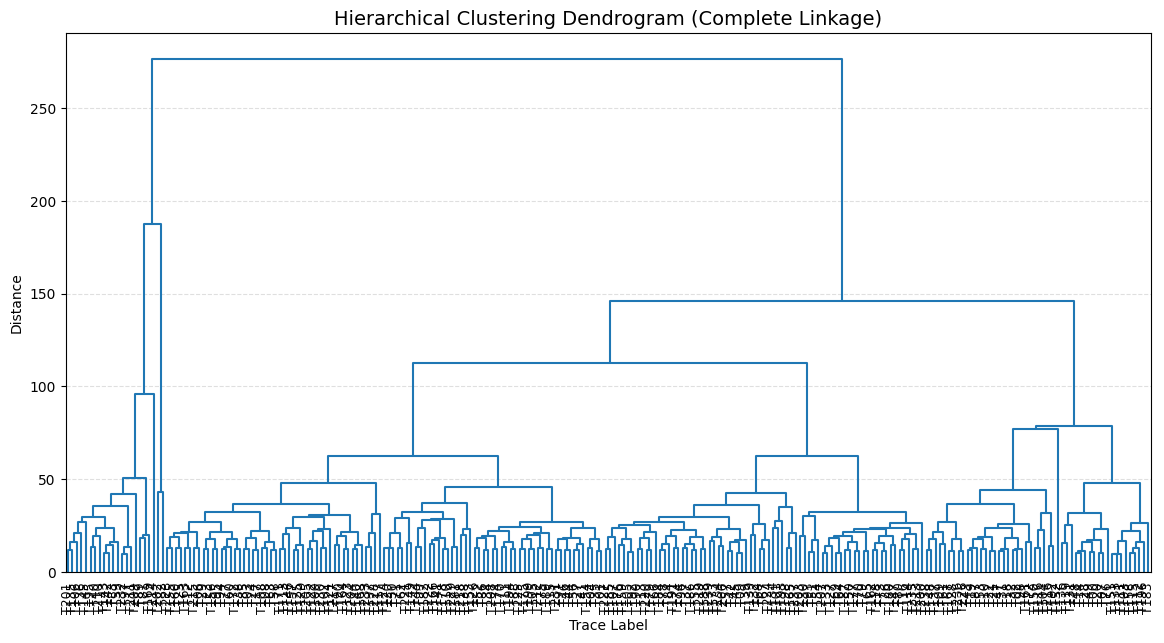


===== Cluster Composition =====

### Cluster 0
 T00 : start → SI → SL → SI → end
 T01 : start → SI → SI → SI → SI → SI → SI → end
 T02 : start → SI → SL → SI → SL → end
 T03 : start → SI → SI → SI → SI → SL → end
 T04 : start → SI → SL → SI → SI → SI → SI → end
 T05 : start → SI → SI → SI → SI → SL → SI → end
 T06 : start → SI → SL → SL → SL → SI → end
 T07 : start → SI → SI → SI → end
 T08 : start → SI → SL → SI → SI → SI → end
 T09 : start → SL → SI → SI → SI → SI → SI → SI → end
 T10 : start → SI → SL → SI → SI → end
 T11 : start → SI → SI → SL → SI → SL → SL → end
 T12 : start → SL → SI → SI → SL → SL → end
 T13 : start → SI → SI → SL → SI → SI → SI → SI → end
 T14 : start → SI → SI → SL → end
 T15 : start → SI → SI → SL → SI → SL → SI → end
 T17 : start → SL → SI → SI → SI → SI → end
 T18 : start → SL → SI → SI → SL → end
 T19 : start → SI → SI → SL → SI → end
 T20 : start → SL → SI → SI → end
 T21 : start → SL → SI → SI → SI → end
 T22 : start → SI → SI → SI → SI → end
 T23 : st

In [18]:
# Dendrogram 확인 후, 적절한 n_clusters 정의 후, sequences 확인
Dendrogram(final_results)

In [19]:
print("cluster 0 : ", len(final_results['cluster_map'].get(0)), "개")
print("cluster 0 : ", len(final_results['cluster_map'].get(1)), "개")
print("cluster 0 : ", len(final_results['cluster_map'].get(2)), "개")

cluster 0 :  813 개
cluster 0 :  69 개
cluster 0 :  3 개


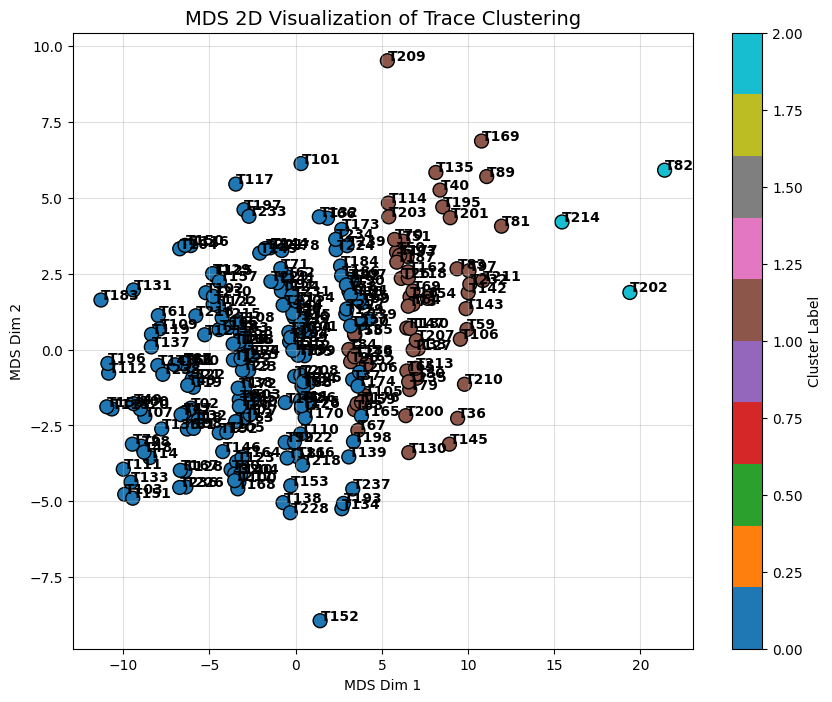

In [20]:
MDS(final_results)

### 4. EDA by Cluster

In [ ]:
from .clustering.utils import clustered_dataframe

In [23]:
clustered_dataframe(final_results, df_filtered)[['processID','cluster']].sample(30)

,processID,cluster
3218,848,0
4251,1106,0
4161,1085,0
5831,959,1
3162,832,0
3491,929,0
2424,631,0
4073,1060,0
4969,401,0
2382,611,1
